# Predict next transaction day

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from contextlib import contextmanager
import time
from preprocessing import *
from feature_engineering import *
from train_evaluate import *
from sklearn.ensemble import RandomForestClassifier
from datetime import date
from xgboost import XGBRFClassifier

In [3]:
@contextmanager
def timer(name):
    time_before_func_call = time.time()
    yield
    time_after_func_call = time.time()
    print('{} - done in {:.0f}s'.format(name, time_after_func_call - time_before_func_call))

<br>
<br>

**Preprocess**

In [4]:
try:
    invoices = pd.read_csv("invoices_2009_2011_no_returns.csv", low_memory=False)
except:
    with timer("Read invoice data"):
        invoices_2011 = pd.read_excel("data/retail/Online_Retail.xlsx")
        invoices_2010 = pd.read_excel("data/retail/online_retail_II.xlsx")
    
    with timer("Preprocess invoice dataframes"):
        invoices_2010 = rename_columns(invoices_2010)
        invoices = concat_invoice_dataframes(invoices_2010, invoices_2011)
        invoices.reset_index(drop=True, inplace=True)
        invoices = add_revenue_column(invoices)
        invoices['StockCode'] = invoices['StockCode'].astype(str)
        invoices = drop_test_invoices(invoices)
        invoices = drop_return_invoices(invoices)
        invoices = drop_non_numeric_invoice_numbers(invoices)
        invoices = clean_stock_codes(invoices)
        invoices.reset_index(drop=True, inplace=True)
        invoices.to_csv("invoices_2009_2011_no_returns.csv", index=False)
        
with timer("Get observation period end dates"):
    observation_end_dates = get_observation_end_dates(invoices)

Read invoice data - done in 115s
Preprocess invoice dataframes - done in 10s
Get observation period end dates - done in 0s


<br>
<br>

**Train & Evaluate**

Get naive labels - done in 20s
Train models - done in 481s
observation period end: 2010-02-01
MODEL - train precision: 0.969, test precision: 0.798, # +Predictions: 84
NAIVE - train precision: 0.759, test precision: 0.68, # +Predictions: 178
---
observation period end: 2010-03-01
MODEL - train precision: 0.829, test precision: 0.749, # +Predictions: 215
NAIVE - train precision: 0.705, test precision: 0.727, # +Predictions: 238
---
observation period end: 2010-04-01
MODEL - train precision: 0.794, test precision: 0.622, # +Predictions: 386
NAIVE - train precision: 0.715, test precision: 0.686, # +Predictions: 283
---
observation period end: 2010-05-01
MODEL - train precision: 0.758, test precision: 0.646, # +Predictions: 328
NAIVE - train precision: 0.698, test precision: 0.63, # +Predictions: 292
---
observation period end: 2010-06-01
MODEL - train precision: 0.741, test precision: 0.679, # +Predictions: 374
NAIVE - train precision: 0.678, test precision: 0.658, # +Predictions: 322
---

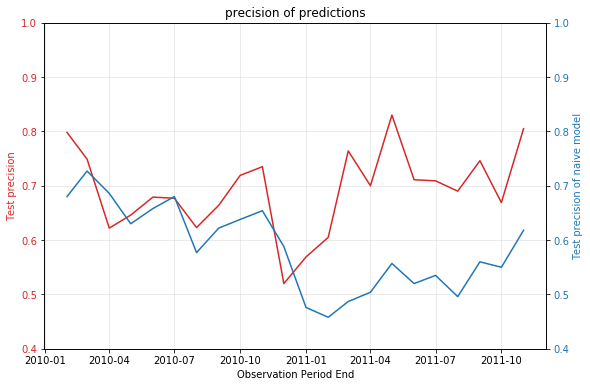

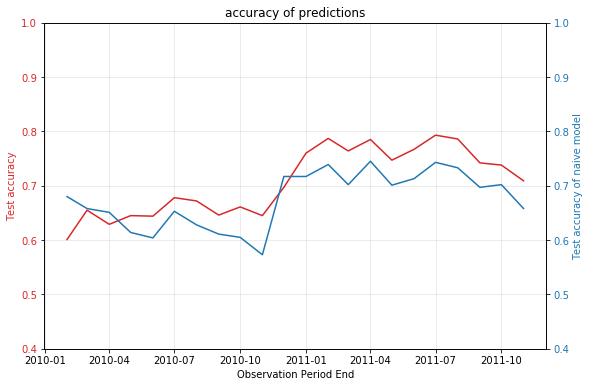

In [5]:
with timer("Get naive labels"):
    naive_labels = get_naive_labels(invoices, observation_end_dates)

with timer("Train models"):
    train_results = train_models(
        RandomForestClassifier, invoices, observation_end_dates, True, 
        n_estimators=1500,
        max_depth=5,
        n_jobs=6
    )
    
with timer("Evaluate models"):
    evaluate_models(train_results, naive_labels, metric='precision', average_all_months=False)
    evaluate_models_by_plotting(train_results, naive_labels, metric='precision')
    evaluate_models_by_plotting(train_results, naive_labels, metric='accuracy')

Example dataset:

- Each row is a customer
- Features are created from all customer purchases up until the observation end date
- A classifier is built using these features to predict whether each customer will purchase within the next month (following the observation end date)

In [13]:
print(f"Observation end date: {train_results['observation_end_dates'][14]}")
train_results['X_train'][14].head()

Observation end date: 2011-04-01


,MeanTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,MaxPurchaseValue,SumPurchaseValue,frequency,recency,T,T_Minus_Recency
0,21.5,13.435029,12.0,31.0,1977.96,3126.25,2.0,44.0,82.0,38.0
1,177.5,4.949747,174.0,181.0,1429.83,2519.01,2.0,356.0,389.0,33.0
2,61.4,45.850845,11.0,110.0,760.69,2563.36,5.0,309.0,392.0,83.0
3,131.5,55.861436,92.0,171.0,690.79,1310.83,2.0,263.0,313.0,50.0
4,109.5,9.192388,103.0,116.0,99.00,276.35,2.0,220.0,340.0,120.0


<br>
<br>

**Single month evaluation**

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1658
           1       0.70      0.28      0.40       573

    accuracy                           0.79      2231
   macro avg       0.75      0.62      0.64      2231
weighted avg       0.77      0.79      0.75      2231



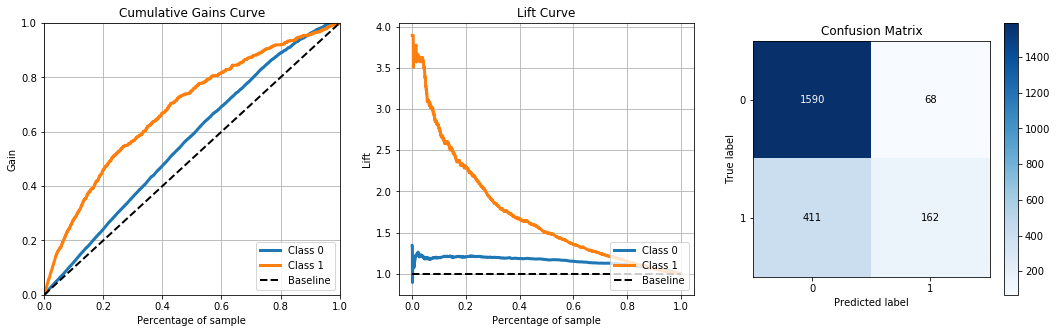

In [15]:
single_month_performance(train_results, date(2011,4,1))

<br>
<br>